<a href="https://colab.research.google.com/github/ParsaPNT128/yelp-recommender/blob/main/yelp_rs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Yelp Recommender System**

## **Data Collection**

In [1]:
!pip install kaggle

In [2]:
!kaggle datasets download -d yelp-dataset/yelp-dataset

Dataset URL: https://www.kaggle.com/datasets/yelp-dataset/yelp-dataset
License(s): other
100% 4.06G/4.07G [00:53<00:00, 133MB/s]
100% 4.07G/4.07G [00:53<00:00, 82.3MB/s]


In [3]:
!unzip /content/yelp-dataset.zip

Archive:  /content/yelp-dataset.zip
  inflating: Dataset_User_Agreement.pdf  
  inflating: yelp_academic_dataset_business.json  
  inflating: yelp_academic_dataset_checkin.json  
  inflating: yelp_academic_dataset_review.json  
  inflating: yelp_academic_dataset_tip.json  
  inflating: yelp_academic_dataset_user.json  


## **Data Preparation**

In [4]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 4.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488490 sha256=eaf97437fa3b122f49b188d7b439363d139de0ce885def92979983d2cc68cd10
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [5]:
from pyspark.ml import Pipeline
from pyspark.sql.functions import *
from pyspark.sql.types import *
from pyspark.ml import Pipeline
from pyspark.sql import SparkSession


spark = SparkSession.builder \
    .appName("Yelp Restaurant Recommendation System") \
    .getOrCreate()

In [6]:
business_df = spark.read.json("yelp_academic_dataset_business.json")
review_df = spark.read.json("yelp_academic_dataset_review.json")
user_df = spark.read.json("yelp_academic_dataset_user.json")

In [7]:
business_df.show(5)
review_df.show(5)
user_df.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{NULL, NULL, NULL...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                NULL|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{NULL, NULL, NULL...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

**Selecting Columns**

In [8]:
business_cols = ['business_id', 'name', 'categories', 'city', 'latitude', 'longitude', 'is_open']
review_cols = ['review_id', 'user_id', 'business_id', 'stars', 'text']
user_cols = ['user_id', 'review_count']

In [9]:
business_df = business_df.select(business_cols)
review_df = review_df.select(review_cols)
user_df = user_df.select(user_cols)

**Filtering**

In [10]:
from pyspark.sql.functions import col

business_df = business_df.filter(business_df["is_open"] == 1)

**Dropping Columns**

In [11]:
business_df = business_df.drop("is_open")

In [12]:
business_df = business_df.dropna()
review_df = review_df.dropna()
user_df = user_df.dropna()

**Adding New ID**

In [13]:
business_newid_df = spark.createDataFrame(business_df.rdd.map(lambda x: x[0]).zipWithIndex(), \
        StructType([StructField("business_id", StringType(), True),StructField("businessId", IntegerType(), True)]))

a = business_df.alias("a")
b = business_newid_df.alias("b")

business_new_df = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.businessId')])

business_new_df.select('businessId','business_id', 'name', 'categories', 'city', 'latitude', 'longitude').show()

+----------+--------------------+--------------------+--------------------+---------------+-------------+---------------+
|businessId|         business_id|                name|          categories|           city|     latitude|      longitude|
+----------+--------------------+--------------------+--------------------+---------------+-------------+---------------+
|        72|knQ4vIgx-r85kjlWV...|Silver and Blue O...|Sporting Goods, S...|           Reno|    39.476518|   -119.7840369|
|       230|1dSKEitDDgIkaApe6...|     The Pepper Pott|Caribbean, Food, ...|      Nashville|   36.1530043|    -86.8433279|
|       434|adATTqggIQX5xxLDI...|        Just Churros|Food Trucks, Rest...|         Tucson|32.2712313189|-110.9920754497|
|       436|vxrGNnuEef7YCfB7m...|             Dunkin'|Coffee & Tea, Don...|  Pinellas Park|   27.8718285|    -82.7502853|
|       469|NQhyMw8SOU1HB-V9X...|Champion Chevrole...|Automotive, Auto ...|           Reno| 39.518222529|-119.7877136963|
|      1034|nBr6NgqcZz1G

In [14]:
user_newid_df = spark.createDataFrame(user_df.rdd.map(lambda x: x[0]).zipWithIndex(), \
        StructType([StructField("user_id", StringType(), True),StructField("userId", IntegerType(), True)]))

a = user_df.alias("a")
b = user_newid_df.alias("b")

user_new_df = a.join(b, col("a.user_id") == col("b.user_id"), 'inner') \
             .select([col('a.'+xx) for xx in a.columns] + [col('b.userId')])

user_new_df.select('userId','user_id').show()

+-------+--------------------+
| userId|             user_id|
+-------+--------------------+
|  27105|---2PmXbF47D870st...|
|  90950|---UgP94gokyCDuB5...|
|  78319|---r61b7EpVPkb4UV...|
|1835336|--0DrQkM0FT-yCQRW...|
|1359651|--0nrvOSAIuhL1Tk4...|
|1552408|--13zE3NaRvLSrmfT...|
|1761222|--1oZcRo9-QKOtTqR...|
| 445484|--1orhUoGFSdHXsox...|
|1675711|--1vcleKg-_ORilNx...|
| 924321|--1xed48O2w6o-TLq...|
|1422611|--238OiSJBDIhfqcS...|
| 298314|--2F5G5LKt3h2cAXJ...|
|1352938|--2eQbUFyRvXKgc-A...|
| 941845|--3Hl2oAvTPlq-f7K...|
|1184588|--3PldvWEZ_bhLNsy...|
|1169121|--3mk6jqZi0Km2kX8...|
| 174173|--4AjktZiHowEIBCM...|
|1657771|--4T2OChSFzSvcYG8...|
| 655164|--4_p6Z3tKadJcr9N...|
|1373434|--4wsx_CrQyZxJYvH...|
+-------+--------------------+
only showing top 20 rows



In [15]:
new_review_df = review_df.select('user_id', 'business_id', 'stars', 'text')

a = new_review_df.alias("a")
b = user_newid_df.alias("b")

review_userId_df = a.join(b, col("a.user_id") == col("b.user_id"), 'inner') \
                     .select([col('a.'+xx) for xx in a.columns] + [col('b.userId')])

a = review_userId_df.alias("a")
b = business_newid_df.alias("b")

review_userId_businessId_df = a.join(b, col("a.business_id") == col("b.business_id"), 'inner') \
                         .select([col('a.'+xx) for xx in a.columns] + [col('b.businessId')])

review_userId_businessId_df.show()

+--------------------+--------------------+-----+--------------------+-------+----------+
|             user_id|         business_id|stars|                text| userId|businessId|
+--------------------+--------------------+-----+--------------------+-------+----------+
|-3-GR6zLPQUQXC02x...|L-VNs3YquPGKVsXl2...|  5.0|So freaking delic...|  92672|     63750|
|-3s52C4zL_DHRK0UL...|L-VNs3YquPGKVsXl2...|  4.0|Great oysters and...|   6441|     63750|
|-3s52C4zL_DHRK0UL...|2IahpaBR4U2Kdy9HF...|  3.0|sweet coffee? wei...|   6441|    102505|
|-3s52C4zL_DHRK0UL...|2IahpaBR4U2Kdy9HF...|  2.0|Another coffee sh...|   6441|    102505|
|-3s52C4zL_DHRK0UL...|WvlCQhLQGza1wj0Ho...|  1.0|Not sure what to ...|   6441|     98226|
|-55DgUo52I3zW9Rxk...|b54tS94cq0r0STDEU...|  5.0|Great hair cut. W...| 621219|     27051|
|-A62H3Q174V1rMWPz...|7hRaOnXRRS8q620F6...|  5.0|I usually visit t...| 471604|    101455|
|-EBZLf7mtJ5MrSvyo...|CBrD7r4PTCAKc7sP_...|  4.0|Absolutely wonder...| 946515|     77707|
|-HYCAMf2m

## **Data Exploration**

In [16]:
business_df.printSchema()
review_df.printSchema()
user_df.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- categories: string (nullable = true)
 |-- city: string (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)

root
 |-- review_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- business_id: string (nullable = true)
 |-- stars: double (nullable = true)
 |-- text: string (nullable = true)

root
 |-- user_id: string (nullable = true)
 |-- review_count: long (nullable = true)



In [17]:
business_df.describe().show()
review_df.describe().show()
user_df.describe().show()

+-------+--------------------+--------------------+--------------------+-----------+------------------+------------------+
|summary|         business_id|                name|          categories|       city|          latitude|         longitude|
+-------+--------------------+--------------------+--------------------+-----------+------------------+------------------+
|  count|              119603|              119603|              119603|     119603|            119603|            119603|
|   mean|                NULL|  1328.6666666666667|                NULL|       NULL|36.621838060656984|-89.46646264373256|
| stddev|                NULL|   851.4687702239388|                NULL|       NULL| 5.884550067556388|14.972558394818144|
|    min|---kPU91CF4Lq2-Wl...|        Grow Academy|3D Printing, Loca...|AB Edmonton|         27.555127|       -120.095137|
|    max|zzw66H6hVjXQEt0Js...|​Silent Stay Medi...|Zoos, Tours, Arts...|    ​Lithia|        53.6791969|    -73.2004570502|
+-------+-------

In [18]:
from pyspark.sql.functions import explode, split, col

business_exploded = business_new_df.withColumn("category", explode(split("categories", ",\s*")))
category_counts = business_exploded.groupBy("category").count().orderBy(col("count").desc())

category_counts.show()

+--------------------+-----+
|            category|count|
+--------------------+-----+
|         Restaurants|34987|
|                Food|20419|
|            Shopping|20186|
|       Home Services|13322|
|       Beauty & Spas|12263|
|    Health & Medical|11046|
|      Local Services|10138|
|          Automotive| 9879|
|           Nightlife| 8379|
|Event Planning & ...| 8173|
|                Bars| 7528|
|         Active Life| 6496|
|          Sandwiches| 6075|
|American (Traditi...| 5531|
|           Fast Food| 5516|
|     Hotels & Travel| 5123|
|               Pizza| 5090|
|       Home & Garden| 5022|
|         Auto Repair| 5003|
|        Coffee & Tea| 4954|
+--------------------+-----+
only showing top 20 rows



In [19]:
reviews_per_business = review_df.groupBy("business_id").count().orderBy(col("count").desc())

reviews_per_business.show()

+--------------------+-----+
|         business_id|count|
+--------------------+-----+
|_ab50qdWOk0DdB6XO...| 7673|
|ac1AeYqs8Z4_e2X5M...| 7516|
|GXFMD0Z4jEVZBCsbP...| 6160|
|ytynqOUb3hjKeJfRj...| 5778|
|oBNrLz4EDhiscSlbO...| 5264|
|iSRTaT9WngzB8JJ2Y...| 5254|
|VQcCL9PiNL_wkGf-u...| 5146|
|_C7QiQQc47AOEv4PE...| 4969|
|GBTPC53ZrG1ZBY3DT...| 4661|
|6a4gLLFSgr-Q6CZXD...| 4480|
|PP3BBaVxZLcJU54uP...| 4293|
|1b5mnK8bMnnju_cvU...| 4247|
|I_3LMZ_1m2mzR0oLI...| 4093|
|VaO-VW3e1kARkU9bP...| 4034|
|qb28j-FNX1_6xm7u3...| 3971|
|gTC8IQ_i8zXytWSly...| 3917|
|yPSejq3_erxo9zdVY...| 3889|
|wz8ZPfySQczcPgSyd...| 3634|
|VVH6k9-ycttH3TV_l...| 3633|
|IkY2ticzHEn4QFn8h...| 3428|
+--------------------+-----+
only showing top 20 rows



In [20]:
reviews_businesses = review_df.join(business_df, "business_id", how="inner")
most_reviewed_cities = reviews_businesses.groupBy("city").count().orderBy(col("count").desc())
most_reviewed_cities = most_reviewed_cities.withColumnRenamed("count", "Number Of Reviews")

most_reviewed_cities.show(10)

+-------------+-----------------+
|         city|Number Of Reviews|
+-------------+-----------------+
| Philadelphia|           744065|
|  New Orleans|           536726|
|        Tampa|           380084|
|    Nashville|           377372|
|       Tucson|           341433|
|         Reno|           295454|
| Indianapolis|           291535|
|Santa Barbara|           224006|
|  Saint Louis|           196382|
|        Boise|            93314|
+-------------+-----------------+
only showing top 10 rows



**Top 20 Cities With The Most Businesses**

In [21]:
!pip install matplotlib

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

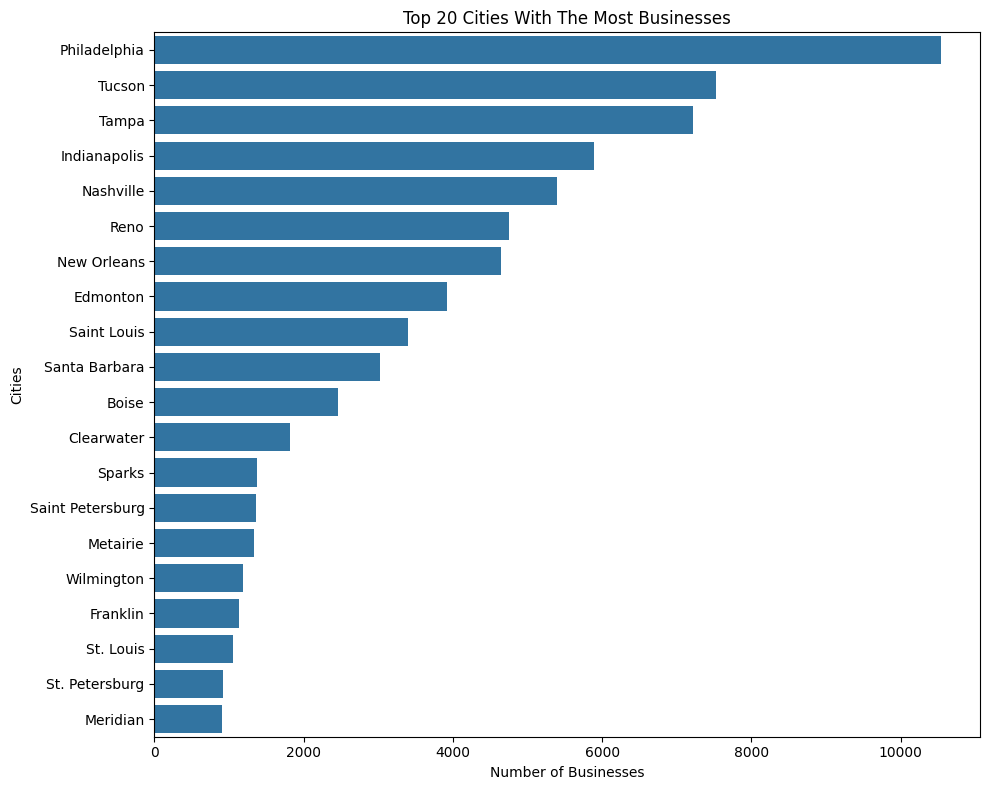

In [23]:
from pyspark.sql.functions import col

most_businesses_cities = business_df.groupBy("city").count().orderBy(col("count").desc())
top_20_cities = most_businesses_cities.limit(20)
top_20_cities_pd = top_20_cities.toPandas()

plt.figure(figsize=(10, 8))
sns.barplot(x="count", y="city", data=top_20_cities_pd)
plt.title("Top 20 Cities With The Most Businesses")
plt.xlabel("Number of Businesses")
plt.ylabel("Cities")
plt.tight_layout()
plt.show()

**Reviews Word Cloud**

In [24]:
!pip install wordcloud

Enter the business name: Forin Cafe


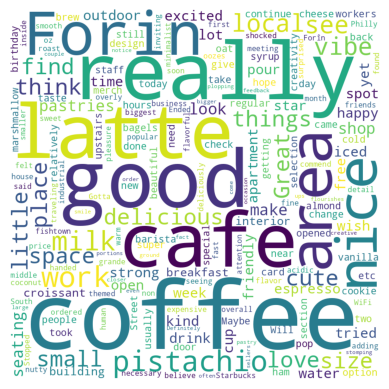

In [25]:
from wordcloud import WordCloud, STOPWORDS
from pyspark.sql.functions import col

def create_wordcloud(df):
  review_list = df.select('text').toPandas()['text'].tolist()
  all_review = ''.join(review_list)

  wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = STOPWORDS,
                min_font_size = 10).generate(all_review)

  plt.imshow(wordcloud)
  plt.axis("off")
  plt.show()

business = input("Enter the business name: ")
business_data = business_df.filter(business_df["name"] == business)

if business_data.count():
  review_data = business_data.join(review_df, on="business_id", how="inner")

  if b.count():
    create_wordcloud(review_data)

  else:
    print("No reviews found.")

else:
  print("Business not found.")

**Filtering Data**

In [26]:
target_cities = ["Edmonton"]
selected_business = business_new_df.filter(business_new_df.city.isin(target_cities))
selected_business.show()

+--------------------+--------------------+--------------------+--------+-------------+---------------+----------+
|         business_id|                name|          categories|    city|     latitude|      longitude|businessId|
+--------------------+--------------------+--------------------+--------+-------------+---------------+----------+
|oo2xOkcHIelQrEczc...|Crystal Glass Sou...|Auto Glass Servic...|Edmonton|    53.449484|    -113.480919|      8324|
|R_3EhO4r3kMSw_W9D...|           Starbucks|  Food, Coffee & Tea|Edmonton|   53.4555859|   -113.5154895|     12365|
|O-ZzRg_RHX1i0hIRV...|    Chateau Lighting|Shopping, Lightin...|Edmonton|   53.4812461|   -113.4853025|     35470|
|pyXKQZ_XmuNLVfgSs...|       Em's Car Wash|Car Wash, Automotive|Edmonton|   53.5054865|   -113.4868477|     35730|
|e4WGdmp_10Cvpv0ZH...|   It's A Dog's Life|Pet Groomers, Pet...|Edmonton|    53.513128|    -113.437394|     48301|
|05qVGl0KbrzU9gbTp...|      Em's Lube Shop|Automotive, Oil C...|Edmonton|   53.5

In [28]:
df_reviews = review_userId_businessId_df.join(selected_business, review_df.business_id == selected_business.business_id)
df_reviews = df_reviews.drop(selected_business.business_id).drop(selected_business.businessId)

In [29]:
reviews_text = df_reviews.select("business_id", "businessId", "text", "stars")
reviews_text.show()

+--------------------+----------+--------------------+-----+
|         business_id|businessId|                text|stars|
+--------------------+----------+--------------------+-----+
|Wr2si_UEmex33UofP...|    100099|Clementine is a v...|  5.0|
|7Ug8vbtGILz5siCLf...|     64566|I really wanted t...|  3.0|
|bzQvlz7oUKFez_XMY...|     97441|I picked my kid u...|  4.0|
|bzQvlz7oUKFez_XMY...|     97441|Probably the long...|  1.0|
|3wLmMcYDXWkiAjLCF...|     56632|I ordered deliver...|  1.0|
|9-uRQkRkXdPQmnU1o...|     10035|I d heard this pl...|  2.0|
|LOzj0BsudeOeqoN5d...|     15614|Always busy as I ...|  4.0|
|LOzj0BsudeOeqoN5d...|     15614|Happy that they a...|  3.0|
|2qHVqbps43bf64Ej4...|     13441|Okay so the chick...|  2.0|
|2qHVqbps43bf64Ej4...|     13441|Delicious chicken...|  4.0|
|l1L4OLwoZIZ23AhXq...|     43357|I just moved to E...|  5.0|
|9-uRQkRkXdPQmnU1o...|     10035|Good ingredients....|  2.0|
|kPG6r0h73sPgXBei0...|      7423|When I first arri...|  4.0|
|kPG6r0h73sPgXBei0...|  

**Pipeline**

In [30]:
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, IDF, Word2Vec, VectorAssembler, Normalizer, HashingTF, Word2VecModel

rt = RegexTokenizer(gaps = False, pattern = '\w+', inputCol = 'text', outputCol = 'token')
swr = StopWordsRemover(inputCol = 'token', outputCol = 'without_stopword')
cv = CountVectorizer(inputCol="without_stopword", outputCol="rawFeature")
idf = IDF(inputCol="rawFeature", outputCol="idf_vector")
w2v = Word2Vec(vectorSize = 100, minCount = 5, inputCol = 'without_stopword', outputCol = 'word_vector', seed = 123)
va = VectorAssembler(inputCols=['idf_vector', 'word_vector'], outputCol='comb_vector')
#norm = Normalizer(inputCol="comb_vector", outputCol="norm_vector")

pipeline = Pipeline(stages=[rt, swr, cv, idf, w2v, va])

In [31]:
pp_model = pipeline.fit(reviews_text)
df = pp_model.transform(reviews_text)
df.show()

+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|         business_id|businessId|                text|stars|               token|    without_stopword|          rawFeature|          idf_vector|         word_vector|         comb_vector|
+--------------------+----------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+
|Wr2si_UEmex33UofP...|    100099|Clementine is a v...|  5.0|[clementine, is, ...|[clementine, spec...|(64164,[1,2,5,6,1...|(64164,[1,2,5,6,1...|[0.01878684718269...|(64264,[1,2,5,6,1...|
|7Ug8vbtGILz5siCLf...|     64566|I really wanted t...|  3.0|[i, really, wante...|[really, wanted, ...|(64164,[5,10,18,2...|(64164,[5,10,18,2...|[-0.0166305881724...|(64264,[5,10,18,2...|
|bzQvlz7oUKFez_XMY...|     97441|I picked my kid u...|  4.0|[i, p

In [32]:
schema = StructType([
    StructField("input_business_id", StringType(), True),
    StructField("business_id", StringType(), True),
    StructField("score", FloatType(), True)
])

In [33]:
'''from difflib import SequenceMatcher

def similar(vec1, vec2):
    return SequenceMatcher(None, vec1, vec2).ratio()'''

'from difflib import SequenceMatcher\n\ndef similar(vec1, vec2):\n    return SequenceMatcher(None, vec1, vec2).ratio()'

In [34]:
def calCosineSim(vec1, vec2):
    return np.dot(vec1, vec2) / (np.sqrt(np.dot(vec1, vec1)) * np.sqrt(np.dot(vec2, vec2)))

In [35]:
business_vectors = df.select('business_id', 'word_vector').rdd.map(lambda x: (x[0], x[1])).collect()

In [36]:
business_vectors

[('Wr2si_UEmex33UofPfLp_Q',
  DenseVector([0.0188, -0.0651, 0.0088, -0.0651, 0.0089, -0.023, 0.0102, -0.0182, -0.0635, 0.0057, 0.016, -0.0714, 0.0071, -0.0173, 0.0074, -0.1428, -0.0018, 0.1274, -0.0986, 0.0133, -0.0329, 0.0438, 0.0445, -0.0364, 0.0693, -0.0203, -0.0347, -0.0012, 0.0367, -0.0083, -0.0624, -0.0451, 0.0147, 0.0268, 0.0198, -0.0125, 0.0107, 0.0096, 0.0773, -0.0345, 0.0086, -0.0689, -0.0126, 0.1048, -0.0281, 0.0723, 0.0135, -0.1873, 0.0872, 0.0672, 0.0247, 0.0251, -0.0473, 0.0316, -0.1381, -0.0417, -0.0058, 0.002, -0.009, -0.0428, 0.04, -0.0008, -0.0326, 0.0084, -0.0185, 0.0286, 0.0175, -0.0099, 0.0445, 0.0201, 0.004, 0.0066, 0.0198, 0.0274, 0.0087, -0.0208, 0.0382, 0.0015, 0.0133, -0.0995, 0.0973, -0.0099, 0.0395, 0.0707, -0.0294, 0.0275, 0.0631, 0.0174, 0.0315, 0.0232, -0.0414, 0.0216, -0.0209, -0.0023, -0.0305, 0.0528, 0.0272, 0.0227, 0.0222, 0.0976])),
 ('7Ug8vbtGILz5siCLftJ21Q',
  DenseVector([-0.0166, -0.0392, -0.0886, 0.0329, 0.0445, -0.0104, 0.0587, 0.0778, -0.067, 

In [37]:
length = len(business_vectors)
print("Length of business_vectors:", length)

Length of business_vectors: 82001
